In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/Shareddrives/Skripsi/dataset/coarse.zip'

Streaming output truncated to the last 5000 lines.
 extracting: coarse/val/reptiles/pachycephalosaurus_s_001100.png  
 extracting: coarse/val/reptiles/pachycephalosaurus_s_001162.png  
 extracting: coarse/val/reptiles/pachycephalosaurus_s_001200.png  
 extracting: coarse/val/reptiles/pachycephalosaurus_s_001214.png  
 extracting: coarse/val/reptiles/pachycephalosaurus_s_001437.png  
 extracting: coarse/val/reptiles/pachycephalosaurus_s_001449.png  
 extracting: coarse/val/reptiles/pisanosaurus_s_000089.png  
 extracting: coarse/val/reptiles/pisanosaurus_s_000097.png  
 extracting: coarse/val/reptiles/ptychozoon_homalocephalum_s_000004.png  
 extracting: coarse/val/reptiles/sea_turtle_s_000016.png  
 extracting: coarse/val/reptiles/sea_turtle_s_000017.png  
 extracting: coarse/val/reptiles/sea_turtle_s_000045.png  
 extracting: coarse/val/reptiles/sea_turtle_s_000057.png  
 extracting: coarse/val/reptiles/sea_turtle_s_000067.png  
 extracting: coarse/val/reptiles/sea_turtle_s_000082.png

In [4]:
import PIL
import cv2
from PIL import Image
DIM=32
def randomcrop(img):
    dim = img.shape
    resized = cv2.resize(img, (int(dim[1]*DIM/dim[0]),int(dim[0]*DIM/dim[0])), interpolation = cv2.INTER_AREA)
    resized=tf.image.random_crop(resized,seed=1, size=(DIM,DIM,3))
    resized=np.array(resized)
    return resized

In [5]:
SEED=42
train_dir='/content/coarse/train'
val_dir='/content/coarse/val'


img_gen = ImageDataGenerator(
    rotation_range=30,
    # rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    # preprocessing_function=randomcrop,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
)
val_img_gen = ImageDataGenerator(
    rescale=1./255,
)
coarse_train_gen=img_gen.flow_from_directory(
    train_dir,
    target_size=(DIM, DIM),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=SEED,
)
coarse_val_gen=val_img_gen.flow_from_directory(
    val_dir,
    target_size=(DIM, DIM),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=SEED,
)


Found 23998 images belonging to 10 classes.
Found 6000 images belonging to 10 classes.


In [6]:
coarse_val_gen.class_indices

{'aquatic_mammals': 0,
 'fish': 1,
 'insects': 2,
 'large_carnivores': 3,
 'large_omnivores_and_herbivores': 4,
 'medium_mammals': 5,
 'non-insect_invertebrates': 6,
 'people': 7,
 'reptiles': 8,
 'small_mammals': 9}

(32, 32, 32, 3)
(32, 32, 3)


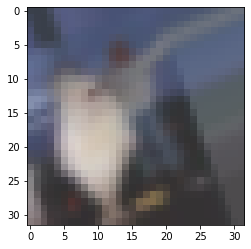

In [7]:
batches=next(coarse_train_gen)  # returns the next batch of images and labels 
print(batches[0].shape) # batch[0] is the images, batch[1] are the labels
img=batches[0][0]   # this is the first image  batch[0][1] would be the next image
print (img.shape)
plt.imshow(img)   # shows the first image

In [8]:
from keras.applications import VGG16, VGG19, MobileNetV2, EfficientNetB7, ResNet50

In [9]:
base_model=VGG16(weights='imagenet', include_top=False, input_shape=(DIM,DIM,3))

base_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [10]:
for layer in base_model.layers[:11]:
    layer.trainable = False

In [11]:
model=keras.Sequential([
    base_model,
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(512,activation='relu'),
    layers.Dense(10,activation='softmax')
])

In [12]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,982,474
Trainable params: 13,246,986
No

In [13]:
from keras.optimizers import Adam

In [14]:
import keras.backend as K
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      recall = true_positives / (possible_positives + K.epsilon())
      return recall

    def precision(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy',f1_score])

In [16]:
earlystop=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    mode="auto",
    restore_best_weights=True,
)

In [17]:
validation_steps=600//32
history1 = model.fit(coarse_train_gen,
          validation_data=coarse_val_gen,
          epochs=100,
          validation_steps=validation_steps,
          verbose=1,
          callbacks=[earlystop]
          )

Epoch 1/100


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


750/750 [==============================] - 44s 45ms/step - loss: 1.9133 - accuracy: 0.3224 - f1_score: 0.1723 - val_loss: 1.6714 - val_accuracy: 0.4167 - val_f1_score: 0.3285
Epoch 2/100
750/750 [==============================] - 30s 40ms/step - loss: 1.6391 - accuracy: 0.4355 - f1_score: 0.3291 - val_loss: 1.4689 - val_accuracy: 0.4948 - val_f1_score: 0.4022
Epoch 3/100
750/750 [==============================] - 30s 40ms/step - loss: 1.5238 - accuracy: 0.4775 - f1_score: 0.3900 - val_loss: 1.3177 - val_accuracy: 0.5365 - val_f1_score: 0.5185
Epoch 4/100
750/750 [==============================] - 30s 39ms/step - loss: 1.4396 - accuracy: 0.5091 - f1_score: 0.4399 - val_loss: 1.3113 - val_accuracy: 0.5538 - val_f1_score: 0.4888
Epoch 5/100
750/750 [==============================] - 30s 39ms/step - loss: 1.3773 - accuracy: 0.5295 - f1_score: 0.4689 - val_loss: 1.3252 - val_accuracy: 0.5573 - val_f1_score: 0.5053
Epoch 6/100
750/750 [==============================] - 30s 39ms/step - loss: 

In [18]:
base_model.trainable=True

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy',f1_score])

validation_steps=600//32
history2 = model.fit(coarse_train_gen,
          validation_data=coarse_val_gen,
          epochs=100,
          validation_steps=validation_steps,
          verbose=1,
          callbacks=[earlystop]
          )

Epoch 1/100
750/750 [==============================] - 32s 41ms/step - loss: 0.6577 - accuracy: 0.7771 - f1_score: 0.7729 - val_loss: 1.3408 - val_accuracy: 0.6198 - val_f1_score: 0.6260
Epoch 2/100
750/750 [==============================] - 32s 42ms/step - loss: 0.6047 - accuracy: 0.7981 - f1_score: 0.7941 - val_loss: 1.1175 - val_accuracy: 0.6493 - val_f1_score: 0.6612
Epoch 3/100
750/750 [==============================] - 33s 44ms/step - loss: 0.5798 - accuracy: 0.8042 - f1_score: 0.8024 - val_loss: 1.1348 - val_accuracy: 0.6389 - val_f1_score: 0.6527
Epoch 4/100
750/750 [==============================] - 31s 41ms/step - loss: 0.5585 - accuracy: 0.8099 - f1_score: 0.8108 - val_loss: 1.2505 - val_accuracy: 0.6389 - val_f1_score: 0.6501
Epoch 5/100
750/750 [==============================] - 31s 41ms/step - loss: 0.5498 - accuracy: 0.8154 - f1_score: 0.8150 - val_loss: 1.3155 - val_accuracy: 0.6389 - val_f1_score: 0.6395
Epoch 6/100
750/750 [==============================] - 32s 42ms/s

In [19]:
model.save('f1_score_coarse_fine_tuned.h5')

In [20]:
!cp 'f1_score_coarse_fine_tuned.h5' '/content/drive/Shareddrives/Skripsi/model/f1/'

In [21]:
def display_history(history, metric='accuracy'):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_{}'.format(metric)])
  plt.title('model {}'.format(metric))
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()


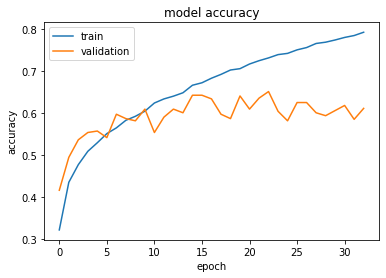

In [22]:
display_history(history1, 'accuracy')

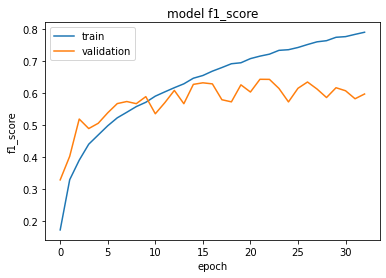

In [23]:
display_history(history1, 'f1_score')

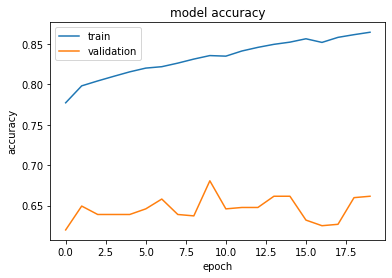

In [24]:
display_history(history2, 'accuracy')

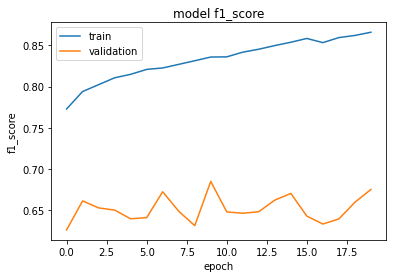

In [25]:
display_history(history2, 'f1_score')